In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import DataLoader 
import numpy as np 
import matplotlib.pyplot as plt 
import data
import gpt 
from tqdm import tqdm, trange
import json 
import matplotlib

device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu' 
if device == 'cuda':
  print(torch.cuda.get_device_name()) 
else: 
  print(device) 

with open('config.json', 'r') as file: 
  config = json.load(file)

lr = config['lr']
bs = config['batch_size']

vocab_size, encode = data._init_data() 

cpu


In [2]:
model = gpt.gpt_model(vocab_size=vocab_size).to(device) 
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters.')
model.load_state_dict(torch.load('/media/uzal/New Volume/hyperion_models/adaptive_span_models/adaptive_span_final_23k.pth'))

59.968665 M parameters.


<All keys matched successfully>

In [3]:
print(data.decode(data.dataloader(split='test')[0][0].tolist()))

es with me and Rachel.
Chandler Bing: Oh, uhm... I have to work too. Yeah, I'm stuck at the office all day.
Phoebe Buffay: Oh, well, it's a shame that you-that you miss the movie 'cause we were gonna see, you know, either "Liar, Liar" or "Betrayal", or... "An Affair To Remember".
Chandler Bing: Those are all really old!
Phoebe Buffay: Ok, then maybe it'll be, uhm...
Rachel Green: "Dude, Where's My Car?"
Phoebe Buffay: What?
Rachel Green: They're in a caaar...
Phoebe Buffay: Okay, we-we'll talk to you later. Okay, bye.
Rachel Green: Geez!
Phoebe Buffay: Ok. Quick. We gotta find a cab and follow them.
Rachel Green: Oh, yeah, ok. Let me just grab my night vision goggles and my stun gun.
Phoebe Buffay: I got them!
TRANSCRIPT_NOTE: 
Chandler Bing: Hi!
Monica Geller: Hey! You smell like perfume and cigarettes.
Chandler Bing: I was in the car with Nancy all day.
Monica Geller: Nancy doesn't smoke!
Chandler Bing: Well, at least the perfume is not mine, be thankful for that!
Monica Geller: So? 

In [4]:
n_heads = config['n_head']
n_blocks = config['n_layer']

In [5]:
def head(x): 
  all_weights = dict() 
  for block_idx in range(n_blocks): 
    for head_idx in range(n_heads): 
      k = model.blocks[block_idx].sa.heads[head_idx].key(x) 
      q = model.blocks[block_idx].sa.heads[head_idx].query(x) 
      weight = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
      weight = weight.masked_fill(model.blocks[block_idx].sa.heads[head_idx].tril[:x.size(1), :x.size(1)] == 0, float('-inf'))
      weight = F.softmax(weight, dim=-1)
      weight2 = model.blocks[block_idx].sa.heads[head_idx].adaptive_span(weight)
      all_weights[f'{block_idx}_{head_idx}'] = weight2
  
  return all_weights

In [6]:
# basically here, we are retracing the forward pass and investigating only the first 
# adaptive span outputs that ultimately multiply with the 'value' and change the 
# output of the self-attention in meaningful ways. 
test_in = (data.dataloader(split='test')[0][0]).unsqueeze(0).to(device)

with torch.no_grad(): 
	# get the token embeddings and the positional embeddings 
	tok_emb = model.token_embedding(test_in)
	pos_emb = model.position_embedding(torch.arange(test_in.size(1), device=device))
	x = tok_emb + pos_emb 
	x = model.blocks[0].ln1(x) 
	# get all the 'weights' that are calculated by the 'keys' and 'values' 
	all_weights = head(x)

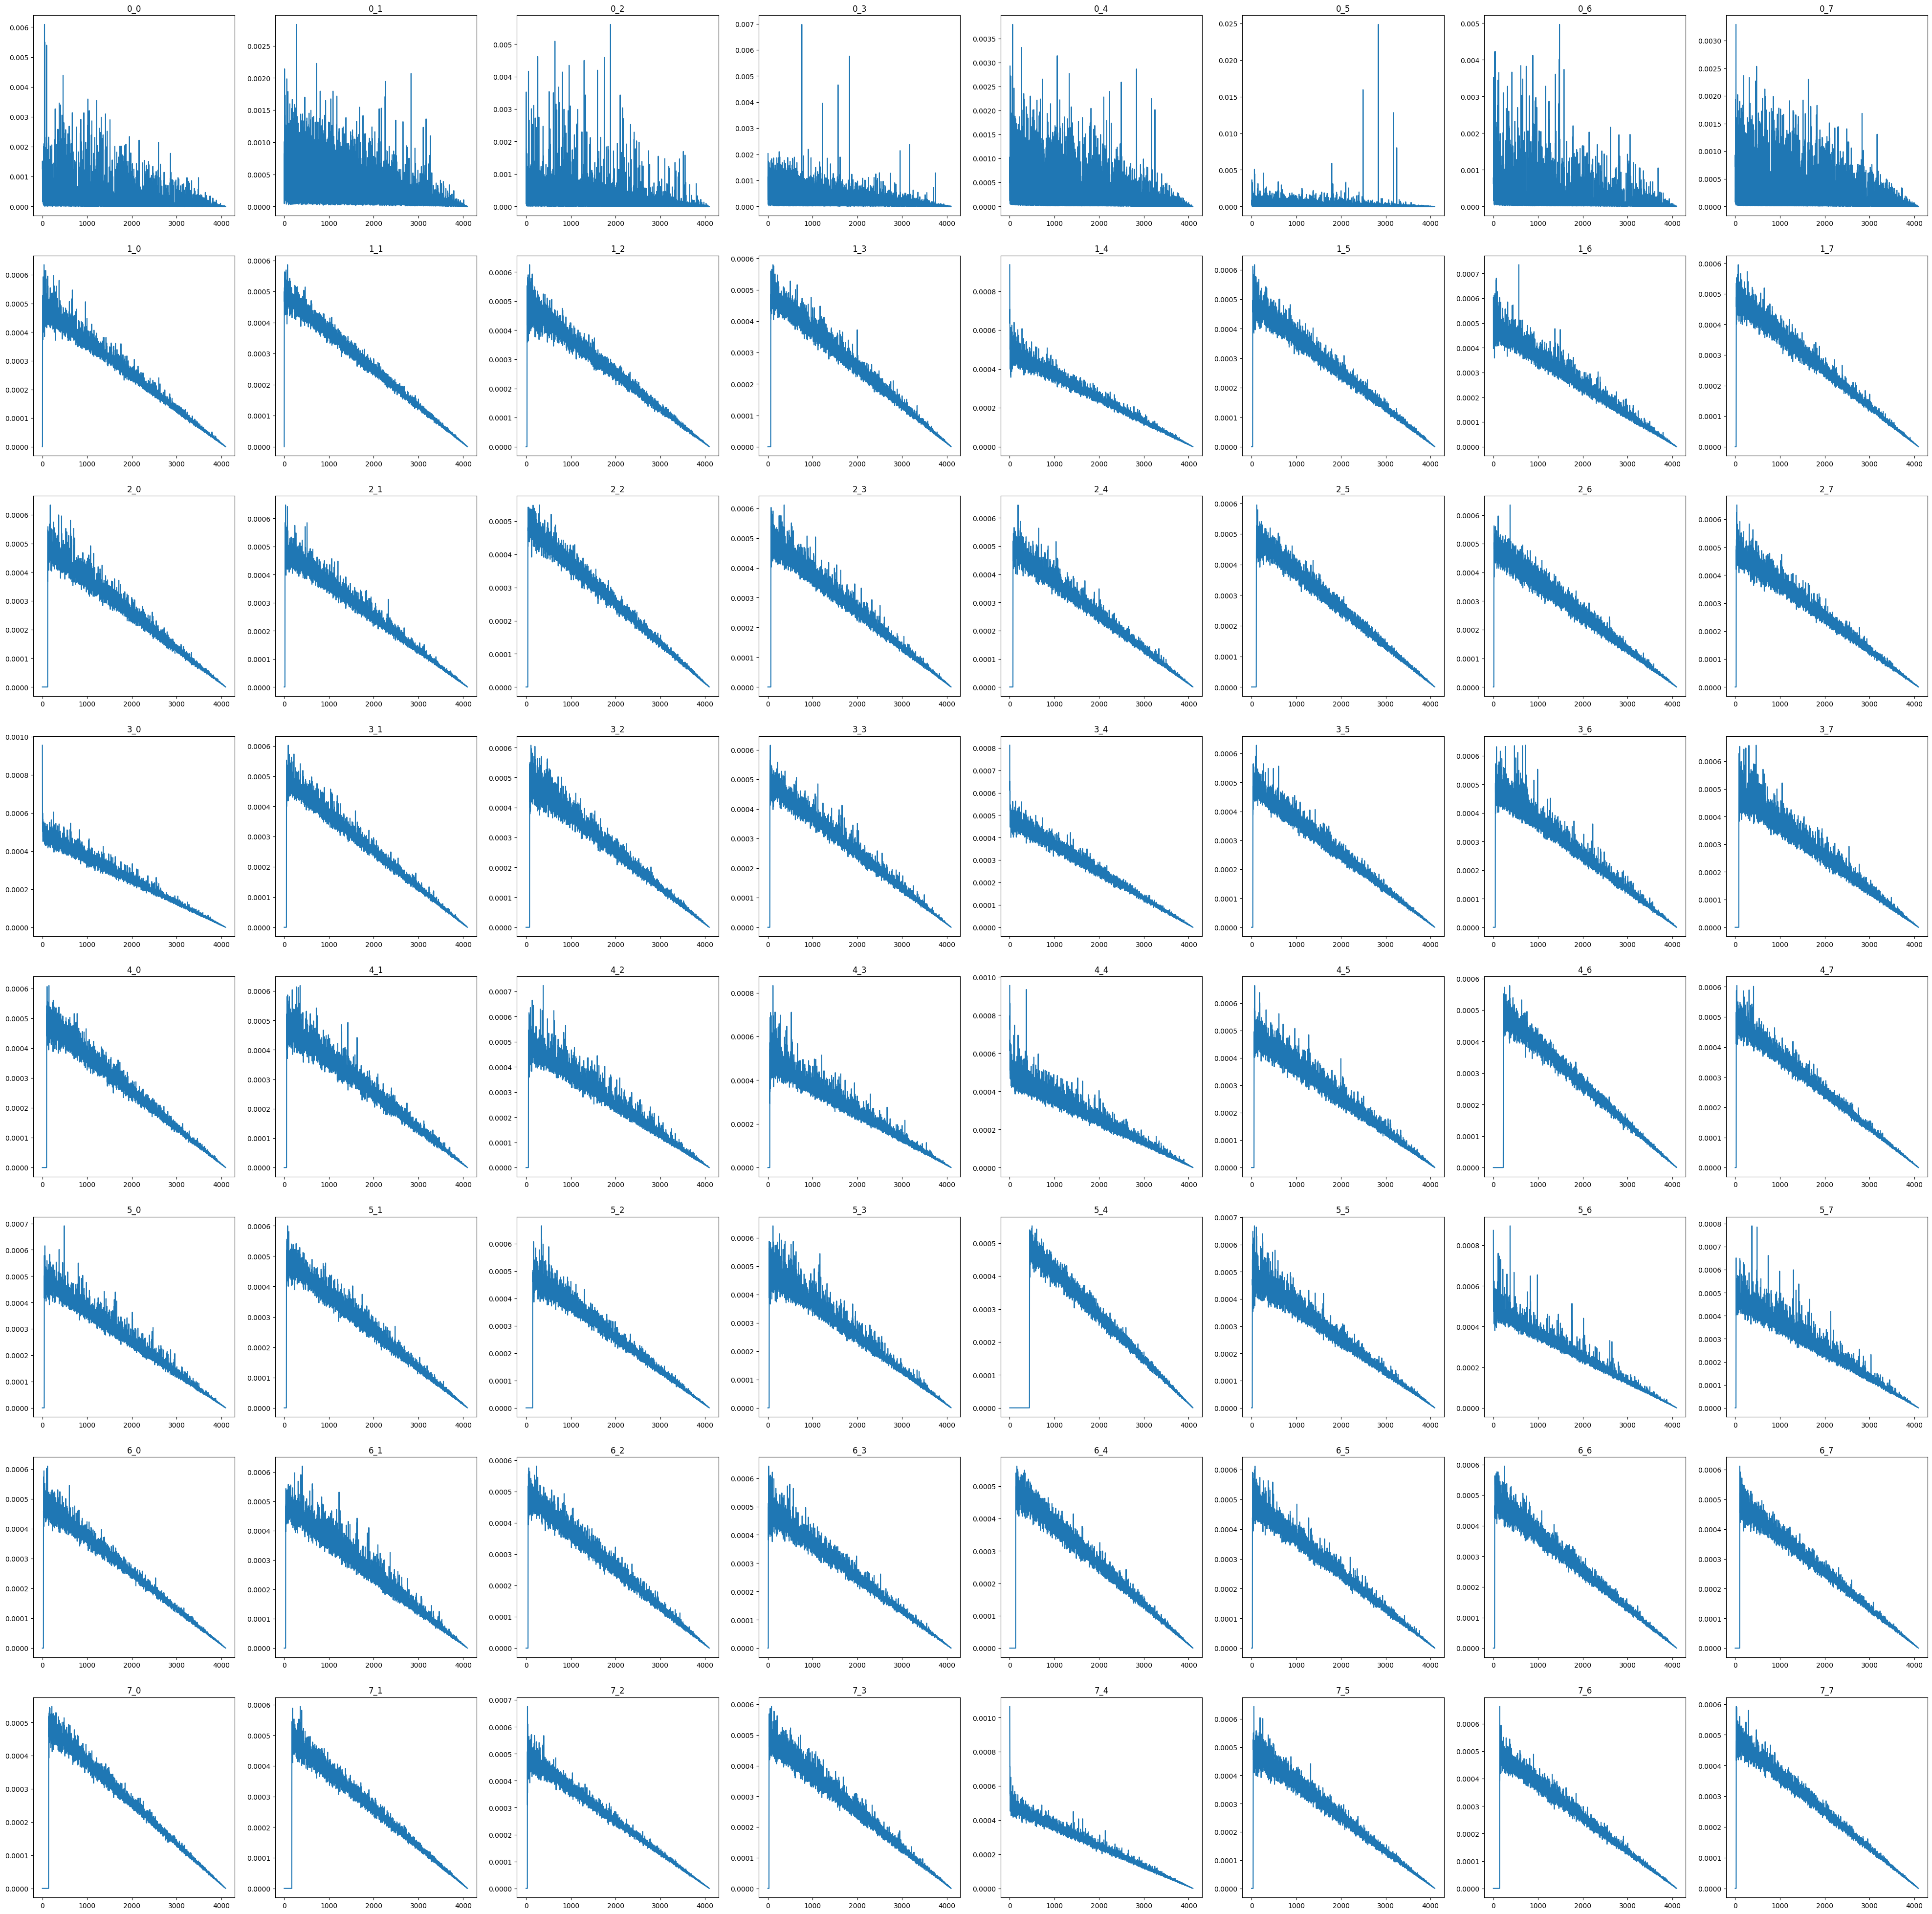

In [7]:
fig, axis = plt.subplots(8, 8)
fig.set_size_inches(50, 50)
for n, i in list(all_weights.items()): 
  axis[int(n[0]), int(n[-1])].plot(i[0].mean(0))
  # axis[int(n[0]), int(n[-1])].set_yscale('log')
  axis[int(n[0]), int(n[-1])].set_title(n)